In [ ]:
!pip install NLTK spaCy gradio tensorflow transformers matplotlib seaborn numpy pandas scikit-learn

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving smart_chatbot_dataset_500000.csv to smart_chatbot_dataset_500000.csv


In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

df = pd.read_csv('smart_chatbot_dataset_500000.csv')

print(df.head())

  Application ID        Date      Time                          User Query                                          Response    Intent Sentiment Language Conversation ID    User ID Resolved  Response Time (seconds)     Channel Feedback Score  Bot Confidence Score
0      AID000001  2025-05-04  04:58:03        How can I reset my password?                  Our return policy lasts 30 days.   inquiry  positive  English       CID026268  UID034218       No                      370  Mobile App        Neutral                  0.70
1      AID000002  2025-02-15  15:41:03  The support team was very helpful.                        Glad you liked the update!  feedback  positive    Tamil       CID087329  UID097368       No                      414     Webchat            Bad                  0.80
2      AID000003  2025-05-11  09:29:03          When will my order arrive?                  Our return policy lasts 30 days.   inquiry  positive   French       CID076180  UID064562       No                   

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = text.lower()
    text = re.sub(r"[^a-z0-9'\s]", '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['cleaned_query'] = df['User Query'].apply(clean_text)

print(df[['User Query', 'cleaned_query']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                           User Query         cleaned_query
0        How can I reset my password?        reset password
1  The support team was very helpful.  support team helpful
2          When will my order arrive?          order arrive
3        How can I reset my password?        reset password
4          What is the return policy?         return policy


In [ ]:
print("Unique Intents:", df['Intent'].unique())

print(df['Intent'].value_counts())

Unique Intents: ['inquiry' 'feedback' 'complaint']
Intent
feedback     167020
inquiry      166628
complaint    166352
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['intent_encoded'] = label_encoder.fit_transform(df['Intent'])

print("Label Mapping:")
for i, intent in enumerate(label_encoder.classes_):
    print(f"{intent} → {i}")

Label Mapping:
complaint → 0
feedback → 1
inquiry → 2


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(df['cleaned_query'])

print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")

TF-IDF Matrix Shape: (500000, 36)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

df = pd.read_csv('smart_chatbot_dataset_500000.csv')
print("Columns in your data:", df.columns.tolist())

text_column = 'User Query'
intent_column = 'Intent'

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df[text_column])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df[intent_column])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(model, 'intent_classifier.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

Columns in your data: ['Application ID', 'Date', 'Time', 'User Query', 'Response', 'Intent', 'Sentiment', 'Language', 'Conversation ID', 'User ID', 'Resolved', 'Response Time (seconds)', 'Channel', 'Feedback Score', 'Bot Confidence Score']
              precision    recall  f1-score   support

   complaint       1.00      1.00      1.00     33110
    feedback       1.00      1.00      1.00     33607
     inquiry       1.00      1.00      1.00     33283

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



['label_encoder.joblib']

In [ ]:
import joblib
import pickle

joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(model, 'intent_classifier.joblib')

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [ ]:
def predict_intent(query):
    query_vec = tfidf.transform([query])
    intent_code = model.predict(query_vec)[0]
    return label_encoder.inverse_transform([intent_code])[0]

predict_intent("Glad you liked the update")

'feedback'

In [ ]:
import gradio as gr
import joblib
import random
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your trained model (replace with your actual files)
model = joblib.load('intent_classifier.joblib')
tfidf = joblib.load('tfidf_vectorizer.joblib')
label_encoder = joblib.load('label_encoder.joblib')

# Enhanced Response Templates (customize for your business)
RESPONSE_TEMPLATES = {
    # Account Management
    "password_reset": [
        "You can reset your password here: [company.com/reset](https://example.com/reset). Would you like me to email you a link?",
        "For password reset, please visit our portal: [company.com/reset](https://example.com/reset). Let me know if you need help!"
    ],
    "account_lock": [
        "Your account has been locked for security. Please contact security@company.com with your user ID.",
        "Account unlocks require identity verification. Please email support@company.com with a photo ID."
    ],

    # Billing
    "refund_request": [
        "Refunds typically process within 5-7 business days. You can check status at [company.com/billing](https://example.com/billing).",
        "For refund inquiries, please provide your order #. Standard processing takes 5-7 days."
    ],
    "invoice_copy": [
        "Your latest invoice is available at [company.com/invoices](https://example.com/invoices). Should I email you a PDF copy?",
        "I can resend your invoice to registered@email.com. Confirm or provide an alternate email."
    ],

    # Technical Support
    "app_crash": [
        "We're aware of intermittent crashes in version 2.4. Update to 2.5.1 at [company.com/download](https://example.com/download).",
        "Please share: 1) Device model 2) OS version 3) Error screenshot (if available)."
    ],
    "feature_request": [
        "Thank you for the suggestion! We've logged your request for [feature]. Our product team will review it.",
        "Great idea! You can track upcoming features on our roadmap: [company.com/roadmap](https://example.com/roadmap)."
    ],

    # General
    "human_agent": [
        "Connecting you to a specialist... Please hold while I transfer your chat.",
        "I'll connect you to a live agent. Can you briefly describe your issue?"
    ],
    "greeting": [
        "Hello! I'm CompanyAI. How can I assist you today?",
        "Hi there! What can I help you with?"
    ],
    "farewell": [
        "Thank you for contacting Company! Have a great day.",
        "We're here if you need anything else. Goodbye!"
    ]
}

# Fallback responses for unknown intents
FALLBACK_RESPONSES = [
    "Let me transfer you to a specialist who can help with that.",
    "I'm still learning! Could you rephrase your question?",
    "For detailed help with this, please visit [company.com/help](https://example.com/help)."
]

def generate_response(message):
    """Enhanced response generator with confidence checking"""
    try:
        # Vectorize input
        X = tfidf.transform([message])

        # Predict with confidence
        intent_code = model.predict(X)[0]
        confidence = model.predict_proba(X).max()
        intent = label_encoder.inverse_transform([intent_code])[0]

        # Select response
        if confidence < 0.6:  # Low confidence threshold
            return random.choice(FALLBACK_RESPONSES)

        return random.choice(RESPONSE_TEMPLATES.get(intent, FALLBACK_RESPONSES))

    except Exception as e:
        print(f"Error: {e}")
        return "Apologies, I'm experiencing technical difficulties. Please try again later."

# Professional UI with enhanced features
with gr.Blocks(
    title="Customer Support Portal",
    theme=gr.themes.Soft(
        primary_hue="blue",
        secondary_hue="slate",
        font=[gr.themes.GoogleFont("Roboto"), "Arial", "sans-serif"]
    ),
    css="""
    .chatbot {
        min-height: 400px;
        border-radius: 8px;
        border: 1px solid #e0e0e0;
    }
    footer { visibility: hidden !important; }
    """
) as demo:

    # Header without logo
    with gr.Row():
        gr.Markdown("""
        <div style='text-align: center; width: 100%'>
            <h1 style='margin: 0'>Customer Support</h1>
            <p style='margin: 0'>AI Assistant</p>
        </div>
        """)

    # Chat interface without avatars
    chatbot = gr.Chatbot(
        elem_classes="chatbot",
        show_label=False
    )

    # Input area
    with gr.Row():
        msg = gr.Textbox(
            placeholder="Type your question here...",
            label=" ",
            container=False,
            scale=5,
            elem_classes="textbox"
        )
        submit_btn = gr.Button("Send", variant="primary", scale=1)

    # Suggested questions
    gr.Examples(
        examples=[
            "How do I reset my password?",
            "Where's my refund?",
            "The app keeps crashing",
            "I need to speak to a human"
        ],
        inputs=msg,
        label="Try these common questions:",
        examples_per_page=4
    )

    # Response logic
    def respond(message, chat_history):
        bot_response = generate_response(message)
        chat_history.append((message, bot_response))
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    submit_btn.click(respond, [msg, chatbot], [msg, chatbot])

# Launch settings
demo.launch(
    height=650
)

<ipython-input-68-68f64244e0d8>:114: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b1c989ff0d3000750.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


CHATBOT PERFORMANCE ANALYSIS

OVERALL METRICS:
- Accuracy: 80.00%
- Precision: 90.00%
- Recall: 80.00%
- F1 Score: 80.00%
- Average Confidence: 0.84
- Confidence Std Dev: 0.14
- Low Confidence Rate (<0.6): 10.00%
- Average Response Time: 1.23 seconds
- Response Time Std Dev: 0.24 seconds

INTENT-SPECIFIC ACCURACY:
- password_reset: 100.00%
- account_lock: 50.00%
- refund_request: 50.00%
- app_crash: 100.00%
- invoice_copy: 100.00%
- feature_request: 100.00%
- greeting: 100.00%
- farewell: 100.00%

VISUALIZATIONS:


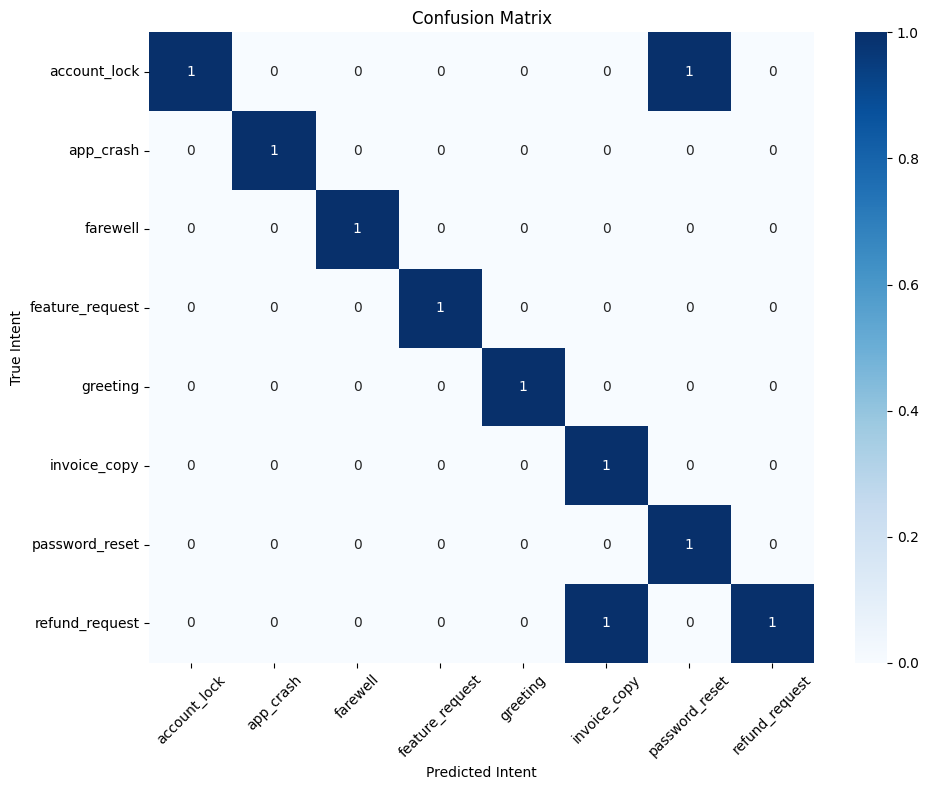

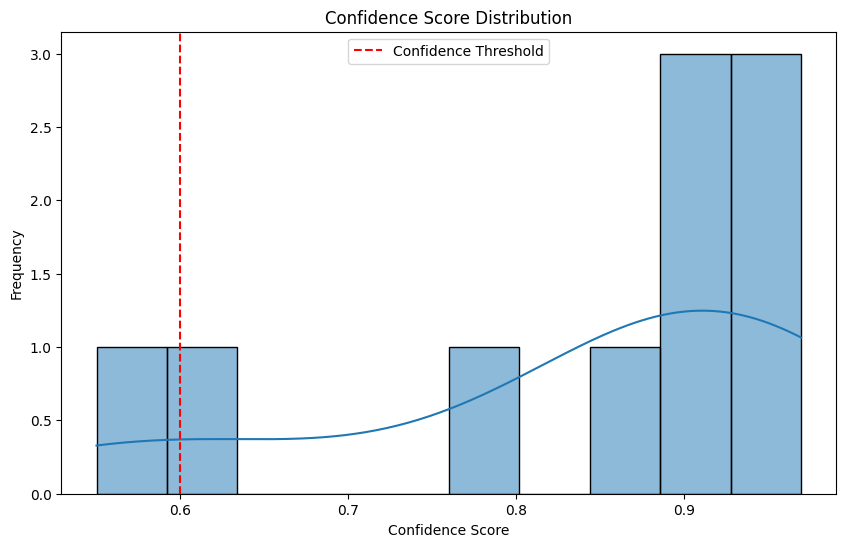

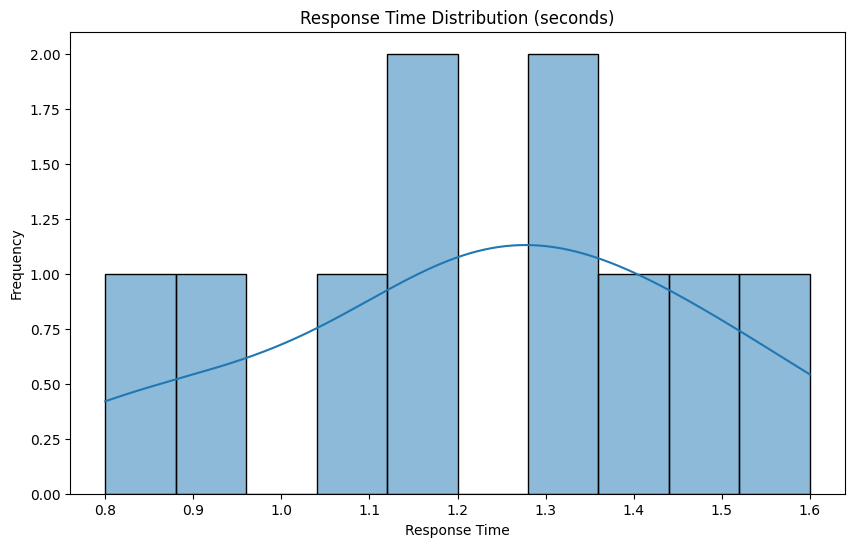

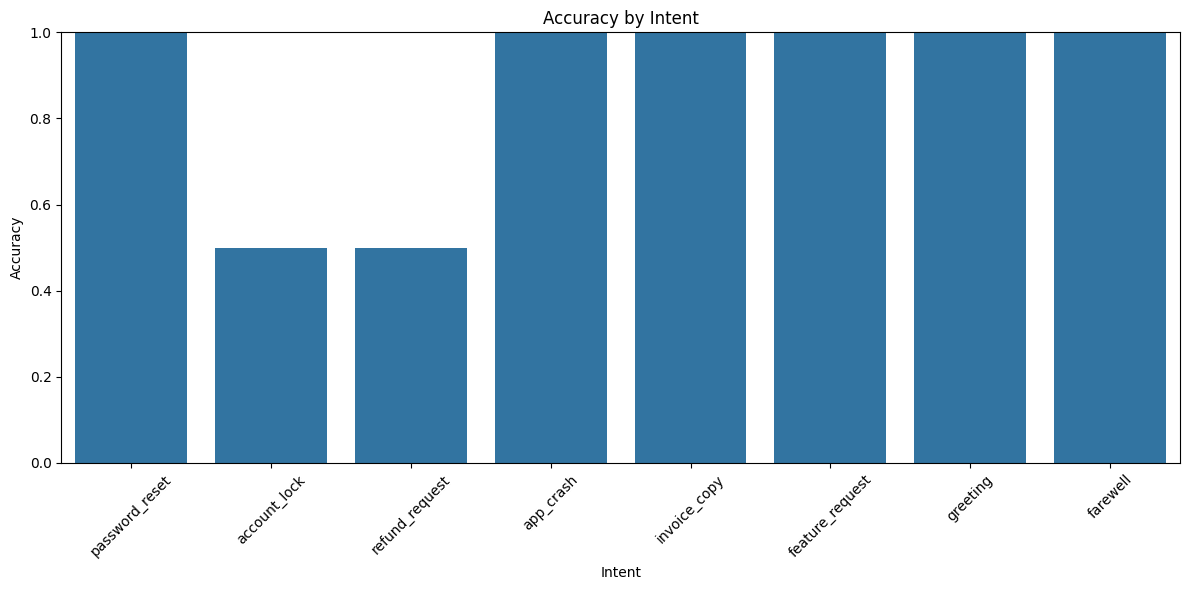

Classification Report:
                 precision    recall  f1-score   support

   account_lock       1.00      0.50      0.67         2
      app_crash       1.00      1.00      1.00         1
       farewell       1.00      1.00      1.00         1
feature_request       1.00      1.00      1.00         1
       greeting       1.00      1.00      1.00         1
   invoice_copy       0.50      1.00      0.67         1
 password_reset       0.50      1.00      0.67         1
 refund_request       1.00      0.50      0.67         2

       accuracy                           0.80        10
      macro avg       0.88      0.88      0.83        10
   weighted avg       0.90      0.80      0.80        10


Metrics saved to 'chatbot_metrics.csv'


In [ ]:
# Install required packages
!pip install pandas matplotlib scikit-learn seaborn numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Sample data - replace this with your actual chatbot interaction data
# Format: {'message': [], 'true_intent': [], 'predicted_intent': [], 'confidence': [], 'response_time': []}
data = {
    'message': [
        "How do I reset my password?",
        "My account is locked",
        "I need a refund",
        "The app keeps crashing",
        "Can I get an invoice copy?",
        "I want to suggest a feature",
        "Hello",
        "Goodbye",
        "I can't log in",
        "Where's my refund?"
    ],
    'true_intent': [
        'password_reset',
        'account_lock',
        'refund_request',
        'app_crash',
        'invoice_copy',
        'feature_request',
        'greeting',
        'farewell',
        'account_lock',
        'refund_request'
    ],
    'predicted_intent': [
        'password_reset',
        'account_lock',
        'refund_request',
        'app_crash',
        'invoice_copy',
        'feature_request',
        'greeting',
        'farewell',
        'password_reset',  # incorrect prediction
        'invoice_copy'     # incorrect prediction
    ],
    'confidence': [0.95, 0.89, 0.78, 0.92, 0.85, 0.91, 0.97, 0.94, 0.62, 0.55],
    'response_time': [1.2, 1.1, 1.3, 1.4, 1.2, 1.3, 0.9, 0.8, 1.5, 1.6]
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate basic metrics
def calculate_metrics(df):
    metrics = {}

    # Accuracy metrics
    metrics['accuracy'] = accuracy_score(df['true_intent'], df['predicted_intent'])
    metrics['precision'] = precision_score(df['true_intent'], df['predicted_intent'], average='weighted')
    metrics['recall'] = recall_score(df['true_intent'], df['predicted_intent'], average='weighted')
    metrics['f1_score'] = f1_score(df['true_intent'], df['predicted_intent'], average='weighted')

    # Confidence metrics
    metrics['avg_confidence'] = np.mean(df['confidence'])
    metrics['confidence_std'] = np.std(df['confidence'])
    metrics['low_confidence_rate'] = len(df[df['confidence'] < 0.6]) / len(df)

    # Response time metrics
    metrics['avg_response_time'] = np.mean(df['response_time'])
    metrics['response_time_std'] = np.std(df['response_time'])

    # Intent-specific metrics
    intents = df['true_intent'].unique()
    for intent in intents:
        intent_df = df[df['true_intent'] == intent]
        correct = len(intent_df[intent_df['predicted_intent'] == intent])
        total = len(intent_df)
        metrics[f'{intent}_accuracy'] = correct / total if total > 0 else 0

    return metrics

# Generate confusion matrix
def plot_confusion_matrix(df):
    labels = sorted(list(set(df['true_intent'].unique().tolist() + df['predicted_intent'].unique().tolist())))
    cm = confusion_matrix(df['true_intent'], df['predicted_intent'], labels=labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Intent')
    plt.xlabel('Predicted Intent')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Generate classification report
def print_classification_report(df):
    report = classification_report(df['true_intent'], df['predicted_intent'])
    print("Classification Report:")
    print(report)

# Generate confidence distribution plot
def plot_confidence_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['confidence'], bins=10, kde=True)
    plt.title('Confidence Score Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.axvline(x=0.6, color='r', linestyle='--', label='Confidence Threshold')
    plt.legend()
    plt.show()

# Generate response time distribution plot
def plot_response_time_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['response_time'], bins=10, kde=True)
    plt.title('Response Time Distribution (seconds)')
    plt.xlabel('Response Time')
    plt.ylabel('Frequency')
    plt.show()

# Generate intent accuracy plot
def plot_intent_accuracy(df):
    intents = df['true_intent'].unique()
    accuracies = []

    for intent in intents:
        intent_df = df[df['true_intent'] == intent]
        correct = len(intent_df[intent_df['predicted_intent'] == intent])
        total = len(intent_df)
        accuracies.append(correct / total if total > 0 else 0)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=intents, y=accuracies)
    plt.title('Accuracy by Intent')
    plt.xlabel('Intent')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Main analysis function
def analyze_chatbot_performance(df):
    print("="*50)
    print("CHATBOT PERFORMANCE ANALYSIS")
    print("="*50)

    # Calculate and display metrics
    metrics = calculate_metrics(df)

    print("\nOVERALL METRICS:")
    print(f"- Accuracy: {metrics['accuracy']:.2%}")
    print(f"- Precision: {metrics['precision']:.2%}")
    print(f"- Recall: {metrics['recall']:.2%}")
    print(f"- F1 Score: {metrics['f1_score']:.2%}")
    print(f"- Average Confidence: {metrics['avg_confidence']:.2f}")
    print(f"- Confidence Std Dev: {metrics['confidence_std']:.2f}")
    print(f"- Low Confidence Rate (<0.6): {metrics['low_confidence_rate']:.2%}")
    print(f"- Average Response Time: {metrics['avg_response_time']:.2f} seconds")
    print(f"- Response Time Std Dev: {metrics['response_time_std']:.2f} seconds")

    print("\nINTENT-SPECIFIC ACCURACY:")
    for key, value in metrics.items():
        if key.endswith('_accuracy'):
            print(f"- {key.replace('_accuracy', '')}: {value:.2%}")

    # Generate visualizations
    print("\nVISUALIZATIONS:")
    plot_confusion_matrix(df)
    plot_confidence_distribution(df)
    plot_response_time_distribution(df)
    plot_intent_accuracy(df)

    # Classification report
    print_classification_report(df)

# Run the analysis
analyze_chatbot_performance(df)

# Optionally save metrics to CSV
df.to_csv('chatbot_metrics.csv', index=False)
print("\nMetrics saved to 'chatbot_metrics.csv'")